# 1. GeoNEX数据的读取转换

## 读取GeoNEX的FY4A数据

In [1]:
import xarray as xr
import numpy
import matplotlib.pyplot as plt

In [2]:
def read_fy4a_nc(nc_path, band_name):
    ds = xr.open_dataset(nc_path)
    b1_dn = ds[band_name].values
    b1_array = numpy.array(b1_dn)
    real_data = b1_array/10000.
    return real_data

In [11]:
# netCDF
nc_path = '/disk2/workspace/20230509/FY4A-_AGRI--_N_DISK_1047E_20210619030000.NC'
real_data = read_fy4a_nc(nc_path, 'Channel03')

In [26]:
real_data.shape # 数据范围 60°S-60°N，44°E-164°E

(12000, 12000)

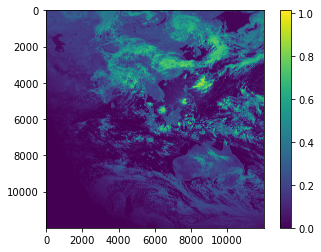

In [27]:
plt.imshow(real_data, interpolation=None)
plt.colorbar()

## 存储为GeoTIFF

In [8]:
from osgeo import gdal
from osgeo import osr

In [9]:
def array2geotiff(tif_path, o_array, llon=44., tlat=60., lat_count=12000, lon_count=12000, pixel_resolution=0.01, no_data_value=-1.):
    file_format = "GTiff"
    full_geotransform = [llon, pixel_resolution, 0, tlat, 0, -pixel_resolution]
    driver = gdal.GetDriverByName(file_format)
    tif_ds = driver.Create(tif_path, lon_count, lat_count, 1, gdal.GDT_Float32)
    tif_ds.SetGeoTransform(full_geotransform)
    srs = osr.SpatialReference()
    srs.ImportFromEPSG(4326)
    tif_ds.SetProjection(srs.ExportToWkt())
    tif_ds.GetRasterBand(1).SetNoDataValue(no_data_value)
    tif_ds.GetRasterBand(1).WriteArray(o_array)
    del tif_ds

In [30]:
tif_path = '/disk2/workspace/20230509/FY4A-_AGRI--_N_DISK_1047E_20210619030000.tif'
array2geotiff(tif_path, real_data)

## 转存为二进制npy文件

In [31]:
npy_path = '/disk2/workspace/20230509/FY4A-_AGRI--_N_DISK_1047E_20210619030000.npy'
numpy.save(npy_path, real_data)

# 2. 选取某区域可视化地理校准

## 截取局部区域

In [5]:
data_folder = '/disk2/workspace/20230510'
nc_path = data_folder + '/FY4A-_AGRI--_N_DISK_1047E_20210619010000.NC'
real_data = read_fy4a_nc(nc_path, 'Channel03')
roi_data = real_data[1000:1500,9600:10100] # 140°-145°E, 45°N-50°N

In [6]:
roi_data.shape

(500, 500)

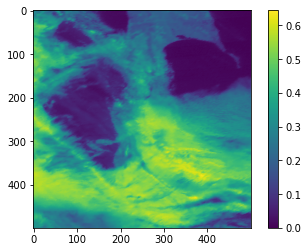

In [7]:
plt.imshow(roi_data, interpolation=None)
plt.colorbar()

## 批量裁剪转存时序数据为GeoTIFF

In [11]:
time_list = ['20210619010000', '20210619020000', '20210619024500', '20210619030000', '20210619031500', '20210619040000', '20210619050000', '20210619054500', '20210619060000', '20210619061500', '20210619070000']
for time_str in time_list:
    nc_path = data_folder + '/FY4A-_AGRI--_N_DISK_1047E_' + time_str + '.NC'
    real_data = read_fy4a_nc(nc_path, 'Channel03')
    roi_data = real_data[1000:1500,9600:10100] # 140°-145°E, 45°N-50°N
    tif_path = data_folder + '/140E_45N_' + time_str + '.tif'
    array2geotiff(tif_path, roi_data, 140., 50., 500, 500)